# Signed Graph Convolutional Network(SGCN)を用いたFraud User Detection

```sh
pip install -r /home/ubuntu/SGCN/requirements.txt
pip install torch_scatter
pip install torch_sparse
pip install easydict
```


In [1]:
from sgcn import SignedGCNTrainer
from parser import parameter_parser
from utils import tab_printer, read_graph, score_printer, save_logs
import argparse
import pandas as pd
import numpy as np
import torch
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import easydict
args = easydict.EasyDict({
        "edge_path": '../input/amazon/amazon_network.csv',#'../input/amazon/user_network.csv',
        "features_path":  '../input/amazon/amazon_node_feature.csv',#'../input/amazon/user_network.csv',
        "nodes_path": '../input/amazon/amazon_gt.csv',
        "embedding_path": '../output/embedding/amazon_sgcn_feature09test.csv',
        "regression_weights_path": '../output/weights/amazon_sgcn_feature09test.csv',
        "log_path": '../logs/amazon_logs_feature09test.json',
        "epochs":1000,
        "test_size":0.9,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 1.0,
        "learning_rate": 0.005,  
        "weight_decay": 10e-5, 
        "layers": [64, 32,16,8],
        "spectral_features":False,
        "general_features": True,  
})

In [3]:
pd.io.json.json_normalize(args).T

,0
edge_path,../input/amazon/amazon_network.csv
embedding_path,../output/embedding/amazon_sgcn_feature09test.csv
epochs,1000
features_path,../input/amazon/amazon_node_feature.csv
general_features,True
lamb,1
layers,"[64, 32, 16, 8]"
learning_rate,0.005
log_path,../logs/amazon_logs_feature09test.json
nodes_path,../input/amazon/amazon_gt.csv


In [4]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [5]:
trainer = SignedGCNTrainer(args, edges, nodes_dict)
trainer.setup_dataset()
trainer.create_and_train_model()

Loss:   0%|          | 0/1000 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.0999): 100%|██████████| 1000/1000 [38:56<00:00,  2.34s/it]


In [6]:
if args.test_size > 0:
    trainer.save_model()
    score_printer(trainer.logs)
    save_logs(args, trainer.logs)


Embedding is saved.


Regression weights are saved.

+-------+-------+-------+
| Epoch |  AUC  |  F1   |
+=======+=======+=======+
| 10    | 0.671 | 0.952 |
+-------+-------+-------+
| 20    | 0.738 | 0.952 |
+-------+-------+-------+
| 30    | 0.765 | 0.952 |
+-------+-------+-------+
| 40    | 0.780 | 0.952 |
+-------+-------+-------+
| 50    | 0.782 | 0.952 |
+-------+-------+-------+
| 60    | 0.776 | 0.952 |
+-------+-------+-------+
| 70    | 0.759 | 0.952 |
+-------+-------+-------+
| 80    | 0.739 | 0.952 |
+-------+-------+-------+
| 90    | 0.735 | 0.952 |
+-------+-------+-------+
| 100   | 0.743 | 0.952 |
+-------+-------+-------+
| 110   | 0.753 | 0.952 |
+-------+-------+-------+
| 120   | 0.750 | 0.952 |
+-------+-------+-------+
| 130   | 0.742 | 0.952 |
+-------+-------+-------+
| 140   | 0.738 | 0.952 |
+-------+-------+-------+
| 150   | 0.730 | 0.952 |
+-------+-------+-------+
| 160   | 0.728 | 0.952 |
+-------+-------+-------+
| 170   | 0.746 | 0.952 |
+-------+-

In [7]:
import json

In [15]:
performance = pd.DataFrame(json.load(open('../logs/amazon_logs_feature09test.json','r'))['performance'])

performance.columns = performance.iloc[0,:]

performance = performance.iloc[1:,:]

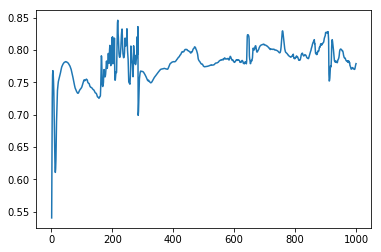

In [16]:
performance['AUC'].plot()

In [22]:
feature = pd.read_csv('../output/embedding/amazon_sgcn_feature09test.csv',index_col='id')

weight = pd.read_csv('../output/weights/amazon_sgcn_feature09test.csv')

In [23]:
predictions = np.dot(feature.values,weight.values.T)

In [24]:
probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [25]:
predict_labels = probabilities.argmax(1)

In [26]:
from sklearn.metrics import accuracy_score,confusion_matrix
confusion_matrix([0 if i==-1 else 1 for i in nodes_dict['label']],predict_labels[nodes_dict['indice']])

array([[ 115,  126],
       [ 125, 2233]])